In [1]:
%load_ext autoreload
%autoreload 2
from evaluation_scripts.experiment_class import Experiment
from evaluation_scripts.statistics import summarize
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import matplotlib.patches as mpatch
from evaluation_scripts.oneway import OneWaySignificance
from style import Style

date = "20220412"
exp = Experiment(date)
Data = exp.data
dt = 4

style = Style("white", fontsize = 20)
palette = sns.color_palette("colorblind")
palette

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

<Figure size 864x576 with 0 Axes>

## Summerize Data

In [2]:
Data["single_resistant"] = (Data.phenotype.isin(["A_r", "B_r", "A&B"]))
Data["resistant"] = (Data.phenotype.isin(["A_r", "B_r", "A&B", "AB_r"]))
Data["U"] = (Data.phenotype == "U")
Data["double_resistant"] = (Data.phenotype == "AB_r")
t_max = max(Data.transfer_n)
Data_end = Data[Data.transfer_n > t_max-dt]
cols = ["strategy", "transfer_n", "rep", "single_resistant", "U", "double_resistant", "resistant"]
Data_end = Data_end[cols]
groups = ["strategy", "rep"]

group_col = "strategy"

alpha = 0.05

In [3]:
summary_u = summarize(Data_end, groups, "U")
summary_res = summarize(Data_end, groups, "single_resistant")
summary_ab = summarize(Data_end, groups, "double_resistant")
summary_r = summarize(Data_end, groups, "resistant")

In [4]:
summaries = [summary_u, summary_res, summary_ab]
labels = ["U_mean", "single_resistant_mean", "double_resistant_mean"]
colors = [palette[-3], palette[-1], palette[2]]
color_dict = dict(zip(labels, colors))
x_offsets = [-0.25, 0, 0.25]
new_dfs = []

for df, col in zip(summaries, labels):
    if col in df.columns:
        new_df = pd.DataFrame({
            'strategy': df['strategy'],
            'f': df[col],
            'profile': col
        })
        new_dfs.append(new_df)
result_df = pd.concat(new_dfs, ignore_index=True)

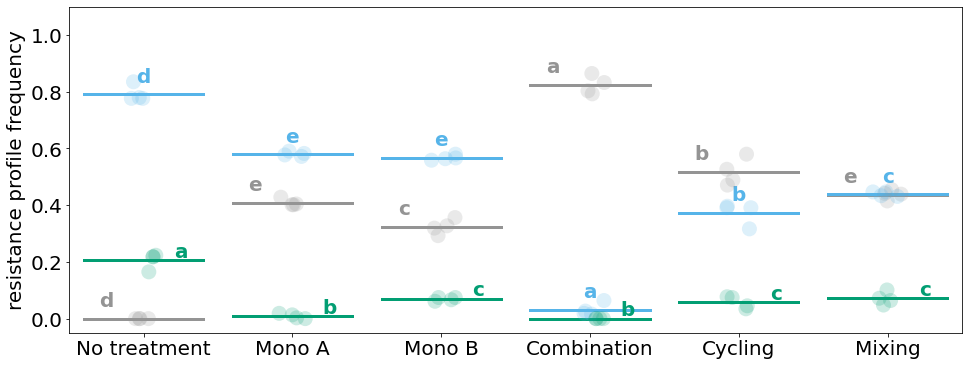

In [5]:
_, ax = style.create_figure_with_style(figsize = (16,6))

for summary,label,color, dx in zip(summaries, labels, colors, x_offsets):
    col = summary.columns[-1]
    significance = OneWaySignificance(summary, "strategy", col)
    significance.plot(dot_color = color,  order = exp.strategies, jitter =.1, violin = False, bar_color = color, strip = False, ax = ax, dx = dx)
    l = label.split("_")[0]
    
    significance.write_anova_results(os.path.join(exp.pathes["tables"], exp.exp +l + "_anova.tex"))
    if significance.anova_pvalue < 0.05:
        significance.write_tukey_results(os.path.join(exp.pathes["tables"], exp.exp +l + "_tukey.tex"))
    
sns.stripplot(data = result_df, 
             y = "f", x = "strategy", hue = "profile", s = 15, order = exp.strategies, palette = color_dict, alpha = .2)
ax.set_ylabel("resistance profile frequency")
ax.set_xlabel(None)
ax.set_ylim([-.05, 1.1])

ax.get_legend().remove()
if exp.exp == "20210417":
    new_handles = []
    for label, color in zip(['uninfected', 'single-resistant', 'double-resistant'], colors):
        new_handles.append(mpatch.Patch(color=color, label=label))
        ax.legend(handles=new_handles, loc='best')

plt.savefig(os.path.join(exp.pathes["analysis"], "ep_anova_"+date+".pdf"), format='pdf')

In [6]:
significance = OneWaySignificance(summaries[0], "strategy", "U_mean")


In [7]:
significance.anova_result

,Sum of Squares,df,Mean Square,F,Sig.
,,,,,
Between Groups,1.431691,5,0.286338,383.053831,0.0
Within Groups,0.013455,18,0.000748,,
Total,1.445146,23,,,


In [8]:
exp.strategies

['No treatment', 'Mono A', 'Mono B', 'Combination', 'Cycling', 'Mixing']